# Custom Decoder Demo Notebook

Welcome to the custom decoder demo notebook! In this notebook, we will showcase the capabilities of SAM's image encoder with custom decoder.

## SAM's Image Encoder

**Image Encoder** in SAM captures essential features from the input image, extracting high-level representations that encode relevant information about objects and their context. This step allows SAM to understand the visual content of the image. Here, we want to use these features and train a custom decoder on the top of that to generate mask.

Let's start by importing the necessary libraries:

In [1]:
import sys

sys.path.append("../")

In [2]:
from segmate.segmenter import SAM
from segmate import utils
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### Initializing SegMate

To start using SegMate, we need to create an instance of the SegMate class. Here, we create an instance called `sm` with the following parameters:

- `model_type`: Specifies the type of model to use. In this case, we are using the `vit_b` model. The options are `vit_b`, `vit_l` and `vit_h`.
- `checkpoint`: Specifies the path to the checkpoint file that contains the pre-trained weights of the model.
- `device`: Specifies the device to run the model on. In this case, we are using the `cuda` device for GPU acceleration.
- `object_detector`: Optional parameter that allows you to provide a custom object detector when you want to use the model with text prompt. If not specified, the default object detector is `None`. You can always add the `object_detector` later.

This instance of the SegMate class serves as our toolkit for performing segmentation tasks with SAM. It encapsulates the model and provides convenient methods for inference and fine-tuning.

Let's create the instance and load the model:

In [3]:
model_checkpoint = '../../sam_vit_h.pth'

In [4]:
sm = SAM(model_type='vit_h', checkpoint=model_checkpoint, device='cuda')

### Using Building Image Segmentation Dataset

In this section, we will demonstrate how to load and utilize the Building Image Segmentation dataset, which is available in the HuggingFace datasets library. We will load the mini version of the dataset and retrieve the bounding box, segmentation mask, and image of a sample from the training set.

To begin, we import the necessary libraries and load the dataset using the `load_dataset()` function from the HuggingFace🤗 datasets library:

In [5]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "full")

### Training a custom decoder for Building Image Segmentation Dataset

In this section, we will demonstrate how to create a PyTorch Dataset instance from the Building Image Segmentation (BIS) dataset and train a custom decoder on this dataset using the SegMate toolkit.

Let's take a look at the code snippet:

In [6]:
from segmate.dataset import BISDataset
from tqdm import tqdm
bis_dataset = BISDataset(dataset=dataset['train'],
                         preprocess=sm.sam.preprocess,
                         img_size=sm.sam.image_encoder.img_size,
                         device=sm.device)

In [7]:
bis_dataloader = torch.utils.data.DataLoader(bis_dataset, batch_size=1, shuffle=False)

In [8]:
train_features = []
train_masks = []
num_samples = 100
n = 0

for input_image, _, gt_mask in tqdm(bis_dataloader):
    if n >= num_samples:
            break
    if gt_mask.shape[2:] == (500, 500):
        with torch.no_grad():
            features = sm.sam.image_encoder(input_image)
        train_features.append(features.cpu().numpy())
        train_masks.append(gt_mask.cpu().numpy())
        n = n + 1

  2%|█▉                                                                              | 166/6764 [00:48<32:17,  3.40it/s]


In [9]:
train_features = np.array(train_features)
train_masks = np.array(train_masks)

In [10]:
train_features.shape

(100, 1, 256, 64, 64)

In [11]:
train_masks.shape

(100, 1, 1, 500, 500)

In [12]:
train_features = train_features.reshape((num_samples, 256, 64, 64))
train_masks = train_masks.reshape((num_samples, 1, 500, 500))

In [13]:
np.save("../../train_features.npy", train_features)
np.save("../../train_masks.npy", train_masks)

In [14]:
train_features = np.load("../../train_features.npy")
train_masks = np.load("../../train_masks.npy")

In [15]:
class SegmentationDecoder(nn.Module):
    def __init__(self, in_channels=256):
        super(SegmentationDecoder, self).__init__()

        # Upsampling layers
        self.upconv1 = nn.ConvTranspose2d(in_channels, 256, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        self.upconv2 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.upconv3 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # Final convolution to reach the desired number of channels (1)
        self.final_conv = nn.Conv2d(128, 1, kernel_size=14)

    def forward(self, x):
        x = self.upconv1(x)
        x = self.relu1(x)

        x = self.upconv2(x)
        x = self.relu2(x)

        x = self.upconv3(x)
        x = self.relu3(x)

        x = self.upconv4(x)
        x = self.relu4(x)

        x = self.final_conv(x)

        return x

In [16]:
decoder = SegmentationDecoder(in_channels=256)
decoder.to(sm.device)

SegmentationDecoder(
  (upconv1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (upconv2): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (upconv3): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (upconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (final_conv): Conv2d(128, 1, kernel_size=(14, 14), stride=(1, 1))
)

In [17]:
num_epochs = 50
bs = 10
lr = 0.001

# Define loss function and optimizer
criterion = nn.MSELoss()

optimizer = optim.Adam(decoder.parameters(), lr=lr)  # Adam optimizer
decoder.train()  # Set the decoder to training mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_tensor = torch.tensor(train_features, dtype=torch.float32).to(device)
y_tensor = torch.tensor(train_masks, dtype=torch.float32).to(device)
train_dataset = TensorDataset(x_tensor, y_tensor)
data_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for features, gt_mask in tqdm(data_loader):
        optimizer.zero_grad()

        output_mask = decoder(features)

        # Calculate the loss            
        loss = criterion(output_mask, gt_mask)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        

    epoch_loss = running_loss / (len(x_tensor) // bs)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.47s/it]


Epoch [1/50] - Loss: 0.1342


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [2/50] - Loss: 0.0744


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [3/50] - Loss: 0.0672


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [4/50] - Loss: 0.0632


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]


Epoch [5/50] - Loss: 0.0593


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch [6/50] - Loss: 0.0563


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [7/50] - Loss: 0.0529


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]


Epoch [8/50] - Loss: 0.0501


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [9/50] - Loss: 0.0478


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [10/50] - Loss: 0.0454


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [11/50] - Loss: 0.0453


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [12/50] - Loss: 0.0443


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [13/50] - Loss: 0.0442


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [14/50] - Loss: 0.0389


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [15/50] - Loss: 0.0360


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [16/50] - Loss: 0.0342


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [17/50] - Loss: 0.0325


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [18/50] - Loss: 0.0313


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [19/50] - Loss: 0.0318


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [20/50] - Loss: 0.0350


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [21/50] - Loss: 0.0332


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [22/50] - Loss: 0.0344


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [23/50] - Loss: 0.0306


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.45s/it]


Epoch [24/50] - Loss: 0.0302


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch [25/50] - Loss: 0.0284


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [26/50] - Loss: 0.0267


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [27/50] - Loss: 0.0245


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [28/50] - Loss: 0.0240


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [29/50] - Loss: 0.0246


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [30/50] - Loss: 0.0240


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [31/50] - Loss: 0.0274


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [32/50] - Loss: 0.0256


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [33/50] - Loss: 0.0234


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [34/50] - Loss: 0.0219


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [35/50] - Loss: 0.0234


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [36/50] - Loss: 0.0208


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [37/50] - Loss: 0.0216


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch [38/50] - Loss: 0.0221


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch [39/50] - Loss: 0.0201


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch [40/50] - Loss: 0.0186


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [41/50] - Loss: 0.0190


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [42/50] - Loss: 0.0177


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [43/50] - Loss: 0.0176


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [44/50] - Loss: 0.0167


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [45/50] - Loss: 0.0163


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch [46/50] - Loss: 0.0165


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [47/50] - Loss: 0.0160


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [48/50] - Loss: 0.0160


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Epoch [49/50] - Loss: 0.0163


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]

Epoch [50/50] - Loss: 0.0163


In [18]:
torch.save(decoder.state_dict(), "../../decoder.pth")

In [19]:
# Set the decoder to evaluation mode
decoder.eval()

SegmentationDecoder(
  (upconv1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (upconv2): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (upconv3): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (upconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (final_conv): Conv2d(128, 1, kernel_size=(14, 14), stride=(1, 1))
)

In [20]:
from segment_anything.utils.transforms import ResizeLongestSide

idx = 12

item = dataset["test"][idx]
image = item["image"]
np_image = np.array(item["image"])
size = np_image.shape[0]

# prepare the image for the model
transform = ResizeLongestSide(1024)
input_image = transform.apply_image(np_image)
input_image = torch.as_tensor(input_image, device=sm.device)
input_image = input_image.permute(2, 0, 1).contiguous()[None, :, :, :]

# preprocess the image
input_image = sm.sam.preprocess(input_image).squeeze()

with torch.no_grad():
    features = sm.sam.image_encoder(input_image.reshape(1, 3, 1024, 1024))
    output_mask = decoder(features)

# get the ground truth segmentation mask
gt_mask = utils.get_segmentation_mask(item["objects"]['segmentation'], size)
gt_mask = gt_mask.reshape((1, 1, size, size)).astype('float32')

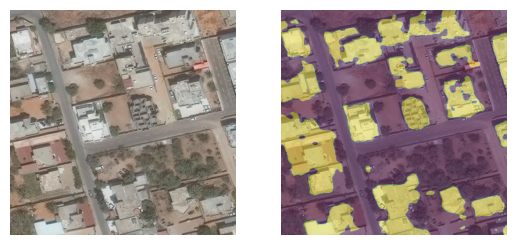

In [21]:
from torch.nn import functional as F

# Apply a threshold to get the binary mask
normalized_mask = (output_mask - output_mask.min()) / (output_mask.max() - output_mask.min())
thresholded_mask = F.threshold(normalized_mask, 0.5, 0)

# Convert the binary mask tensor to a numpy array and remove the batch dimension
binary_mask = thresholded_mask.squeeze(0).cpu().numpy()
binary_mask = np.expand_dims(binary_mask, axis=0)
utils.show_masks(np_image, binary_mask)

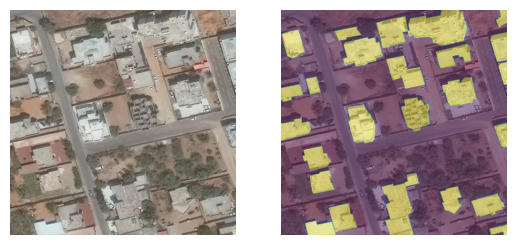

In [22]:
utils.show_masks(np_image, gt_mask)